# WordPiece tokenization

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT, Funnel Transformers, and MPNET. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.

In [1]:
from IPython.display import HTML

HTML('<iframe width="430" height="320" src="https://www.youtube.com/embed/qpv6ms_t_1A" title="WordPiece Tokenization" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/hpshin/.local/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This section covers WordPiece in depth, going as far as showing a full implementation. You can skip to the end if you just want a general overview of the tokenization algorithm.

⚠️ Google never open-sourced its implementation of the training algorithm of WordPiece, so what follows is our best guess based on the published literature. It may not be 100% accurate.

Like BPE, **WordPiece starts from a small vocabulary including the special tokens used by the model and the initial alphabet**. Since it identifies subwords by adding a prefix (like ## for BERT), **each word is initially split by adding that prefix to all the characters inside the word.** So, for instance, "word" gets split like this:

In [ ]:
w ##o ##r ##d

Thus, the initial alphabet contains all the characters present at the beginning of a word and the characters present inside a word preceded by the WordPiece prefix.

Then, again like BPE, WordPiece learns merge rules. **The main difference is the way the pair to be merged is selected.** Instead of selecting the most frequent pair, **WordPiece computes a score for each pair, using the following formula:**

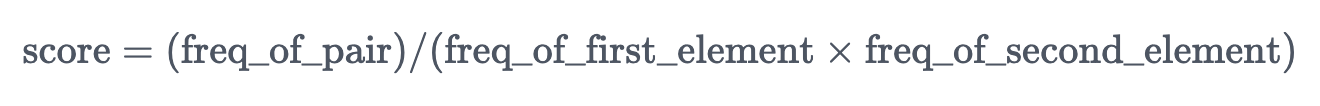


By dividing the frequency of the pair by the product of the frequencies of each of its parts, **the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary.** For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

Let’s look at the same vocabulary we used in the BPE training example:

In [ ]:
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)

The splits here will be:

In [ ]:
("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)

so the initial vocabulary will be ["b", "h", "p", "##g", "##n", "##s", "##u"] (if we forget about special tokens for now). The most frequent pair is ("##u", "##g") (present 20 times), but the individual frequency of "##u" is very high, so its score is not the highest (it’s 1 / 36). All pairs with a "##u" actually have that same score (1 / 36), so the best score goes to the pair ("##g", "##s") — the only one without a "##u" — at 1 / 20, and the first merge learned is ("##g", "##s") -> ("##gs").

Note that when we merge, we remove the ## between the two tokens, so we add "##gs" to the vocabulary and apply the merge in the words of the corpus:

In [ ]:
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs"]
Corpus: ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##gs", 5)

At this point, "##u" is in all the possible pairs, so they all end up with the same score. Let’s say that in this case, the first pair is merged, so ("h", "##u") -> "hu". This takes us to:

In [ ]:
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu"]
Corpus: ("hu" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)

Then the next best score is shared by ("hu", "##g") and ("hu", "##gs") (with 1/15, compared to 1/21 for all the other pairs), so the first pair with the biggest score is merged:

In [ ]:
Vocabulary: ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
Corpus: ("hug", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)

and we continue like this until we reach the desired vocabulary size.

✏️ Now your turn! What will the next merge rule be?

## Tokenization algorithm

Tokenization differs in WordPiece and BPE in that **WordPiece only saves the final vocabulary, not the merge rules learned**. **Starting from the word to tokenize, WordPiece finds the longest subword that is in the vocabulary, then splits on it**\. For instance, if we use the vocabulary learned in the example above, for the word "hugs" the longest subword starting from the beginning that is inside the vocabulary is "hug", so we split there and get ["hug", "##s"]. We then continue with "##s", which is in the vocabulary, so the tokenization of "hugs" is ["hug", "##s"].

**With BPE, we would have applied the merges learned in order and tokenized this as ["hu", "##gs"], so the encoding is different.**

As another example, let’s see how the word "bugs" would be tokenized. "b" is the longest subword starting at the beginning of the word that is in the vocabulary, so we split there and get ["b", "##ugs"]. Then "##u" is the longest subword starting at the beginning of "##ugs" that is in the vocabulary, so we split there and get ["b", "##u, "##gs"]. Finally, "##gs" is in the vocabulary, so this last list is the tokenization of "bugs".

When the tokenization gets to a stage where it’s not possible to find a subword in the vocabulary, **the whole word is tokenized as unknown** — so, for instance, "mug" would be tokenized as ["[UNK]"], as would "bum" (even if we can begin with "b" and "##u", "##m" is not the vocabulary, and the resulting tokenization will just be ["[UNK]"], not ["b", "##u", "[UNK]"]). This is another difference from BPE, which would only classify the individual characters not in the vocabulary as unknown.

✏️ Now your turn! How will the word "pugs" be tokenized?

## Implementing WordPiece

Now let’s take a look at an implementation of the WordPiece algorithm. Like with BPE, this is just pedagogical, and you won’t able to use this on a big corpus.

We will use the same corpus as in the BPE example:

In [1]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

First, we need to pre-tokenize the corpus into words. Since we are replicating a WordPiece tokenizer (like BERT), we will use the bert-base-cased tokenizer for the pre-tokenization:

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

2022-11-27 18:13:47.707202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 18:13:47.868063: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-27 18:13:47.898901: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 18:13:48.364594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Then we compute the frequencies of each word in the corpus as we do the pre-tokenization:

In [3]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

As we saw before, the alphabet is the unique set composed of all the first letters of words, and all the other letters that appear in words prefixed by ##:

In [4]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


We also add the special tokens used by the model at the beginning of that vocabulary. In the case of BERT, it’s the list ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]:

In [5]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

Next we need to split each word, with all the letters that are not the first prefixed by ##:

In [6]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

Now that we are ready for training, let’s write a function that computes the score of each pair. We’ll need to use this at each step of the training:

In [7]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

Let’s have a look at a part of this dictionary after the initial splits:

In [8]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('T', '##h'): 0.125
('##h', '##i'): 0.03409090909090909
('##i', '##s'): 0.02727272727272727
('i', '##s'): 0.1
('t', '##h'): 0.03571428571428571
('##h', '##e'): 0.011904761904761904


Now, finding the pair with the best score only takes a quick loop:

In [9]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('a', '##b') 0.2


So the first merge to learn is ('a', '##b') -> 'ab', and we add 'ab' to the vocabulary:

In [10]:
vocab.append("ab")

In [11]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

And we can have a look at the result of the first merge:

In [12]:
splits = merge_pair("a", "##b", splits)
splits["about"]

['ab', '##o', '##u', '##t']

Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 70:

In [13]:
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

We can then look at the generated vocabulary:

In [14]:
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut']


As we can see, compared to BPE, **this tokenizer learns parts of words as tokens a bit faster.**

💡 Using train_new_from_iterator() on the same corpus won’t result in the exact same vocabulary. This is because the 🤗 Tokenizers library does not implement WordPiece for the training (since we are not completely sure of its internals), but uses BPE instead.

To tokenize a new text, we pre-tokenize it, split it, then apply the tokenization algorithm on each word. That is, **we look for the biggest subword starting at the beginning of the first word and split it, then we repeat the process on the second part, and so on for the rest of that word and the following words in the text:**

In [15]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

Let’s test it on one word that’s in the vocabulary, and another that isn’t:

In [16]:
print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


Now, let’s write a function that tokenizes a text:

In [17]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

We can try it on any text:

In [18]:
tokenize("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

That’s it for the WordPiece algorithm! Now let’s take a look at Unigram.